In [1]:
import numpy as np
import meshplot as mp
import networkx as nx
import sys

from src.mesh_gen import vec3
sys.modules['vec3'] = vec3
from vec3 import Vec3, Interpolada
from src.mesh_gen.modelador import GrafoCentros
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [7]:
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
z = np.linspace(-2, 2, 100)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)

xs = [ Vec3(xi, yi, zi) for xi, yi, zi in zip(x,y,z) ]
curvaInterpolada = Interpolada( xs )

In [8]:
def generarCurvaRadios( radios, correccion = 1 ):
    cantPuntos = len(radios)    
    bordeIzq = np.linspace( np.power(10, correccion), radios[0], cantPuntos )
    bordeDer = np.linspace( radios[-1], np.power(10, correccion), cantPuntos )
    radiosTotales = np.concatenate( [ bordeIzq, radios, bordeDer ])
    
    primerIndice = ( 1 / len(radiosTotales) ) * cantPuntos
    ultimoIndice = ( 1 / len(radiosTotales) ) * (cantPuntos + len(radios))
    
    curva = Interpolada(radiosTotales)
    curva.reparametrizar( lambda x : (ultimoIndice - primerIndice)*x + primerIndice )
    
    return curva, ( -primerIndice / (ultimoIndice - primerIndice) + 0.01, (1-primerIndice) / (ultimoIndice - primerIndice) - 0.01)
    
radiosInterpolados, limites = generarCurvaRadios( np.power( np.linspace(-1,1,10), 2 ) + 1, correccion = 1)

/tmp/ipykernel_6953/2100831480.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


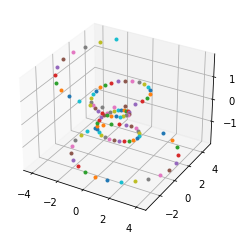

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')

for t in np.arange(0, 1, 0.01):
    v = curvaInterpolada.evaluar(t)
    ax.plot(v.x, v.y, v.z, marker='.')

plt.show()

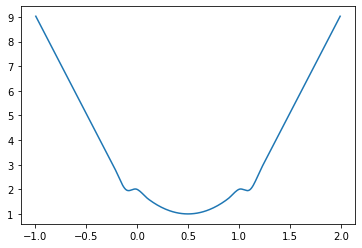

In [10]:
xs = np.arange(limites[0], limites[1], 0.01)
plt.figure()
plt.plot( xs, [radiosInterpolados.evaluar(i) for i in xs ] )

In [11]:
def curvatura( puntos ):
    curvaturas = []

    for i in range(1, len(puntos) - 1):
        p1 = puntos[i+1] - puntos[i]
        p2 = puntos[i-1] - puntos[i]

        angulo = p1.angleTo( p2, p1.cross(p2).normalizar() )

        curvaturas.append( angulo / (p1.norm2() + p2.norm2()))
        
    return curvaturas

def generarCurvaCurvatura( curvaturas, correccion = 1):
    cantPuntos = len(curvaturas)
    bordeIzq = list(reversed( np.exp(np.linspace(0, -10, cantPuntos) * correccion)* curvaturas[0] + 0.5 ) )
    bordeDer = np.exp( np.linspace(0, -10, cantPuntos) * correccion ) * curvaturas[-1] + 0.5
    curvaturasTotales = np.concatenate( [ bordeIzq, curvaturas, bordeDer ])
    
    primerIndice = ( 1 / len(curvaturasTotales) ) * cantPuntos
    ultimoIndice = ( 1 / len(curvaturasTotales) ) * (cantPuntos + len(curvaturas))
    
    curva = Interpolada(curvaturasTotales)
    curva.reparametrizar( lambda x : (ultimoIndice - primerIndice)*x + primerIndice )
    
    return curva, ( -primerIndice / (ultimoIndice - primerIndice) + 0.01, (1-primerIndice) / (ultimoIndice - primerIndice) - 0.01)

In [12]:
curvaturas = curvatura( [ curvaInterpolada.evaluar(t) for t in np.arange(0, 1, 0.001) ] )
curvaturasInterpoladas, limites2 = generarCurvaCurvatura(curvaturas, correccion = 1.2)

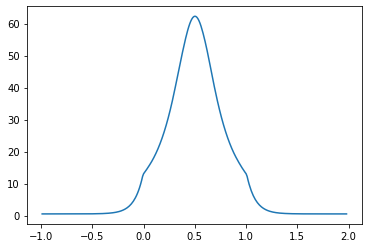

In [13]:
xs = np.arange(limites2[0], limites2[1], 0.01)
plt.figure()
plt.plot( xs, np.array([ curvaturasInterpoladas.evaluar(i) for i in xs ]) )

In [313]:
alpha = 0.1
beta = 0.2

def termino( j ):
    try:
        return radiosInterpolados.evaluar(j) / (1 + beta * curvaturasInterpoladas.evaluar(j))
    except:
        return radiosInterpolados.evaluar(1.3) / (1 + beta * curvaturasInterpoladas.evaluar(1.3))
    
peso = 0.001
sigmoide = lambda x : 1 / (1 + np.exp(-10*x))
f = lambda x, y: np.exp( -x + y )
h = lambda x, y: -x + f(0,y)
g = lambda x, y: h(x,y) * sigmoide(-x) + f(x,y) * sigmoide(x)

def C1( xs ):
    return np.sum( 
        [ g( xs[0], 1 / len(xs) )]+
        [ g( xs[i+1] - xs[i], 1 / len(xs) ) for i in range(0, len(xs)-1)] +
        [ g( 1 - xs[-1], 1 / len(xs) )] )

def C2( xs ):
    return np.sum( 
        [ g( curvaInterpolada[xs[0]].distTo(curvaInterpolada[0]), 2 *radiosInterpolados[0] )]+
        [ g( curvaInterpolada[xs[i+1]].distTo(curvaInterpolada[xs[i]]), 2* radiosInterpolados[xs[i]] ) for i in range(0, len(xs)-1)] +
        [ g( curvaInterpolada[xs[-1]].distTo(curvaInterpolada[1]), 2 *radiosInterpolados[xs[1]] )] )

def C4( xs ):
    return np.sum( 
        [ g( xs[0], alpha * (termino(0) + termino(xs[0])) )]+
        [ g( xs[i+1] - xs[i], alpha* (termino(xs[i]) + termino(xs[i+1])) ) for i in range(0, len(xs)-1)] +
        [ g( 1 - xs[-1], alpha*(termino(xs[1]) + termino(1) ) )] )

def C3( xs ):
    return C1( xs ) + peso * C4(xs)


In [314]:
C3( [0.25, 0.5, 0.75])

4.369126133279995

In [315]:
ts = np.linspace(0.1, 0.9, 40)
p = minimize( C3, ts )

In [316]:
print( p.x, C3( p.x ), C1(p.x), C4(p.x))

[0.04982264 0.09236614 0.13032925 0.16407246 0.19447016 0.22154613
 0.24643647 0.26889502 0.28991219 0.30999331 0.33011972 0.35002187
 0.36911696 0.38750721 0.40544687 0.42313677 0.44061301 0.45783359
 0.47497026 0.49206483 0.5090788  0.52616484 0.54329904 0.5605312
 0.57802425 0.59577124 0.6137713  0.63222032 0.65138798 0.67150324
 0.69200707 0.71277032 0.73493312 0.75944328 0.78577387 0.81517189
 0.84621433 0.87908098 0.91743997 0.95799661] 41.07632189580401 41.03158128772828 44.74060807572949


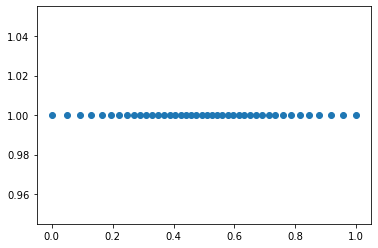

In [317]:
plt.scatter(np.concatenate( [[0],p.x,[1]]), np.ones(len(p.x)+2) )

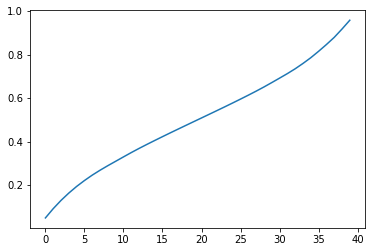

In [318]:
plt.plot( np.arange(0, len(p.x)), p.x )

/tmp/ipykernel_6953/1342460748.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


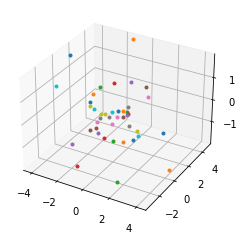

In [322]:
fig = plt.figure()
ax = fig.gca(projection='3d')

for t in np.concatenate([ [0], p.x, [1]]):
    if t <= 1:
        v = curvaInterpolada.evaluar(t)
        ax.plot(v.x, v.y, v.z, marker='.')

plt.show()

## Datos Intra:

In [2]:
def prepararAristas( grafo ):
    for arista in grafo.edges():
        nx.set_edge_attributes( grafo, {arista : {'procesada':False}})

def armarGrafo( file ):
    grafo = nx.read_gpickle(file)
    prepararAristas(grafo)
    return GrafoCentros( grafo )

shading = { 'width': 500, 'height': 400, 'bbox':True, 'point_size': 1,"side": "DoubleSide" }

In [19]:
MODELO = "models/grafos/ArteryObjAN1-4-grafo.gpickle"

In [20]:
GC = armarGrafo(MODELO)
curvasPosiciones, curvasRadios, curvasCurvaturas = GC.obtenerCurvas()
GC.tile()
GC.subdivide(1)
p = mp.plot( GC.getVertices(), GC.getCaras(), c=np.array([0.7, 0.0, 0.0]), shading=shading, return_plot=True)
p.add_points( GC.getVertices(), shading=shading)

Renderer(camera=PerspectiveCamera(aspect=1.25, children=(DirectionalLight(color='white', intensity=0.6, positi…

1

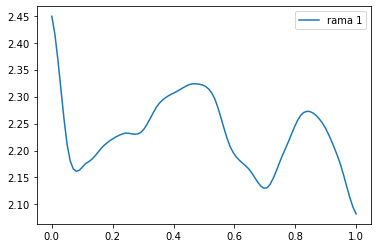

In [22]:
xs = np.linspace(0,1,100)
plt.figure()
plt.plot( xs, np.array([ curvasRadios[0].evaluar(i) for i in xs ]),label="rama 1" )
#plt.plot( xs, np.array([ curvasRadios[1].evaluar(i) for i in xs ]),label="rama 2" )
#plt.plot( xs, np.array([ curvasRadios[2].evaluar(i) for i in xs ]),label="rama 3")
plt.legend()

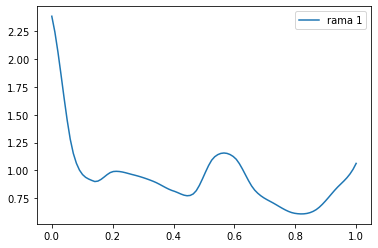

In [23]:
xs = np.linspace(0,1,100)
plt.figure()
plt.plot( xs, np.array([ curvasCurvaturas[0].evaluar(i) for i in xs ]),label="rama 1" )
#plt.plot( xs, np.array([ curvasCurvaturas[1].evaluar(i) for i in xs ]),label="rama 2" )
#plt.plot( xs, np.array([ curvasCurvaturas[2].evaluar(i) for i in xs ]),label="rama 3")
plt.legend()

/tmp/ipykernel_12535/3197311214.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


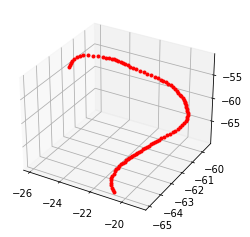

In [24]:
fig = plt.figure()
ax = fig.gca(projection='3d')

for rama,color in zip(curvasPosiciones, ['red','green','blue']):
    for t in np.arange(0, 1, 0.01):
        v = rama.evaluar(t)
        ax.plot( v.x, v.y, v.z, marker='.', color=color )

plt.show()

In [39]:
def resamplear( radiosInterpolados, curvaturasInterpoladas, cantPuntos ):
    alpha = 0.1
    beta = 0.1
    peso = 0.01

    def termino( j ):
        try:
            return radiosInterpolados.evaluar(j) / (1 + beta * curvaturasInterpoladas.evaluar(j))
        except:
            return radiosInterpolados.evaluar(1.3) / (1 + beta * curvaturasInterpoladas.evaluar(1.3))

    sigmoide = lambda x : 1 / (1 + np.exp(-10*x))
    f = lambda x, y: np.exp( -x + y )
    h = lambda x, y: -x + f(0,y)
    g = lambda x, y: h(x,y) * sigmoide(-x) + f(x,y) * sigmoide(x)

    def C1( xs ):
        return np.sum( 
            [ g( xs[0], 1 / len(xs) )]+
            [ g( xs[i+1] - xs[i], 1 / len(xs) ) for i in range(0, len(xs)-1)] +
            [ g( 1 - xs[-1], 1 / len(xs) )] )

    def C4( xs ):
        return np.sum( 
            [ g( xs[0], alpha * (termino(0) + termino(xs[0])) )]+
            [ g( xs[i+1] - xs[i], alpha* (termino(xs[i]) + termino(xs[i+1])) ) for i in range(0, len(xs)-1)] +
            [ g( 1 - xs[-1], alpha*(termino(xs[1]) + termino(1) ) )] )

    def C3( xs ):
        return C1( xs ) + peso * C4(xs)
    
    paso = 1 / cantPuntos
    ts = np.linspace(0 + paso, 1 - paso, cantPuntos)
    return minimize( C3, ts )

In [40]:
ps = []
for radios, curvaturas in zip(curvasRadios, curvasCurvaturas):
    ps.append(resamplear(radios,curvaturas,30))

/tmp/ipykernel_12535/1044843191.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


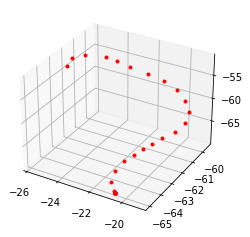

In [41]:
fig = plt.figure()
ax = fig.gca(projection='3d')

for curva, p,color in zip(curvasPosiciones, ps, ['red','green','blue']):
    curva.reparametrizar( lambda x: np.clip(x,0,1))
    for t in np.concatenate( [ [0], p.x, [1]]):
        v = curva.evaluar(t)
        ax.plot( v.x, v.y, v.z, marker='.', color=color )

plt.show()